In [20]:
import pandas as pd
import numpy as np
import pymc as pm
from src.data_utils import load_and_process_data
from src.model import run_full_analysis, build_and_sample_model
from src.trace_save_load import load_previous_season_trace, extract_previous_season_priors, save_season_trace
import matplotlib.pyplot as plt

league = ['Premier_League']
season = '2025-2026'



In [21]:
# Simple one-liner to get everything ready
df, team_mapping, n_teams = load_and_process_data(
    db_path=r'/Users/admin/dev/algobetting/infra/data/db/fotmob.db',
    league=league, 
    season=season,
    max_goals=9,
    decay_rate=0.002, 
    goals_weight=0.18,
    xg_weight=0.45,
    psxg_weight=0.27,
    epv_weight=0.1

)

df.tail() 

,match_id,league_id,match_date,home_team,away_team,home_goals,away_goals,weight,days_ago,is_actual,poisson_binomial_xg_prob,poisson_binomial_psxg_prob,poisson_xg_total_prob,poisson_epv_prob,home_idx,away_idx
7277,4813594,Premier_League,2026-01-18,Wolves,Newcastle,2,1,0.01,8,False,0.01,0.00,0.01,0.00,19,14
7278,4813594,Premier_League,2026-01-18,Wolves,Newcastle,2,2,0.00,8,False,0.01,0.00,0.01,0.00,19,14
7279,4813594,Premier_League,2026-01-18,Wolves,Newcastle,2,3,0.00,8,False,0.00,0.00,0.00,0.00,19,14
7280,4813594,Premier_League,2026-01-18,Wolves,Newcastle,3,0,0.00,8,False,0.00,0.00,0.00,0.00,19,14
7281,4813594,Premier_League,2026-01-18,Wolves,Newcastle,3,1,0.00,8,False,0.00,0.00,0.00,0.00,19,14


In [22]:
goals = df[df['is_actual'] == True]

average_goasl = (goals['home_goals'] + goals['away_goals'])

print("NON PENALTY")
print('============')
average_goasl.mean()

NON PENALTY


np.float64(2.5608695652173914)

In [23]:
df[df["match_id"] == 4813453]["weight"].sum()

np.float64(0.820369853137831)

In [24]:
# manual priors

# Attack strength priors (mu, sigma)
# Using sigma=0.1 for tighter priors based on historical data
manual_att_priors = {
    'Arsenal': (0.198, 0.25),
    'Aston Villa': (0.121, 0.25),
    'Bournemouth': (0.100, 0.25),
    'Brentford': (0.079, 0.25),
    'Brighton': (0.083, 0.25),
    'Chelsea': (0.185, 0.25),
    'Crystal Palace': (0.057, 0.25),
    'Everton': (-0.108, 0.25),
    'Fulham': (-0.030, 0.25),
    'Liverpool': (0.371, 0.25),
    'Man City': (0.297, 0.25),
    'Man United': (0.011, 0.25),
    'Newcastle': (0.207, 0.25),
    'Nottm Forest': (-0.003, 0.25),
    'Tottenham': (0.121, 0.25),
    'West Ham': (-0.082, 0.25),
    'Wolves': (-0.094, 0.25),

    'Burnley': (-0.401, 0.3),
    'Leeds': (-0.103, 0.3),
    'Sunderland': (-0.553, 0.3)
}

# Defense strength priors (mu, sigma)
# Using sigma=0.1 for tighter priors based on historical data
manual_def_priors = {
    'Arsenal': (-0.340, 0.25),
    'Aston Villa': (-0.085, 0.25),
    'Bournemouth': (-0.001, 0.25),
    'Brentford': (-0.054, 0.25),
    'Brighton': (0.107, 0.25),
    'Chelsea': (-0.166, 0.25),
    'Crystal Palace': (0.052, 0.25),
    'Everton': (-0.085, 0.25),
    'Fulham': (-0.014, 0.25),
    'Liverpool': (-0.222, 0.25),
    'Man City': (-0.191, 0.25),
    'Man United': (-0.035, 0.25),
    'Newcastle': (-0.083, 0.25),
    'Nottm Forest': (-0.046, 0.25),
    'Tottenham': (0.163, 0.25),
    'West Ham': (0.103, 0.25),
    'Wolves': (0.137, 0.25),

    'Burnley': (0.163, 0.3),
    'Leeds': (0.163, 0.3),
    'Sunderland': (0.231, 0.3)
}



In [25]:
model, trace = build_and_sample_model(
     df, 
     n_teams, 
     team_mapping=team_mapping,
     trace=20000,
     tune=10000,
     manual_att_priors=manual_att_priors,
     manual_def_priors=manual_def_priors
 )

                 mean   sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
att_str_raw[0]   0.24 0.16   -0.06     0.52       0.00     0.00   5314.00   2871.00   1.00
att_str_raw[1]   0.14 0.16   -0.16     0.44       0.00     0.00   5340.00   3128.00   1.00
att_str_raw[2]   0.12 0.16   -0.18     0.42       0.00     0.00   5593.00   3006.00   1.00
att_str_raw[3]   0.08 0.16   -0.21     0.38       0.00     0.00   6138.00   3509.00   1.00
att_str_raw[4]   0.08 0.17   -0.21     0.40       0.00     0.00   5577.00   3242.00   1.00
att_str_raw[5]  -0.33 0.19   -0.68     0.03       0.00     0.00   7512.00   3054.00   1.00
att_str_raw[6]   0.24 0.16   -0.04     0.54       0.00     0.00   5745.00   3214.00   1.00
att_str_raw[7]   0.03 0.16   -0.27     0.34       0.00     0.00   5967.00   3397.00   1.00
att_str_raw[8]  -0.13 0.17   -0.43     0.21       0.00     0.00   7060.00   2928.00   1.00
att_str_raw[9]  -0.01 0.17   -0.33     0.32       0.00     0.00   5704.00   2672.00   1.00

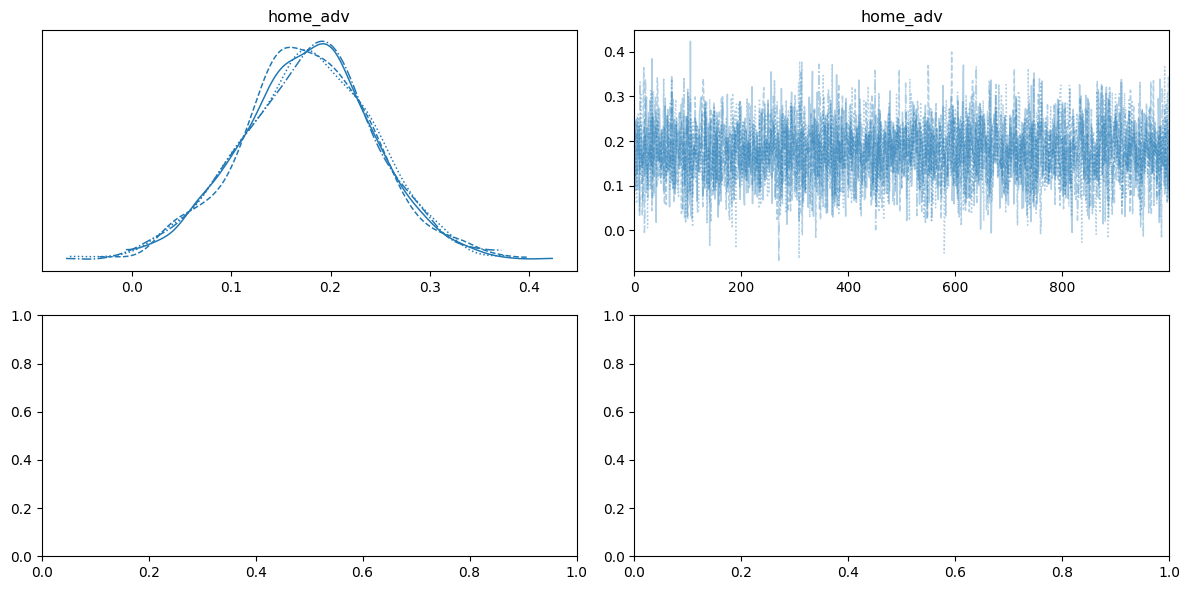

In [26]:
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd

# Quick summary - full table display with 2 decimal places
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)  # Prevents wrapping
pd.set_option('display.precision', 3)  # 2 decimal places

summary = az.summary(trace)
print(summary)

# Quick plots
fig, axes = plt.subplots(2, 2, figsize=(12, 6))

# Trace plots for key parameters
az.plot_trace(trace, var_names=['home_adv'], axes=axes)
plt.tight_layout()
plt.show()


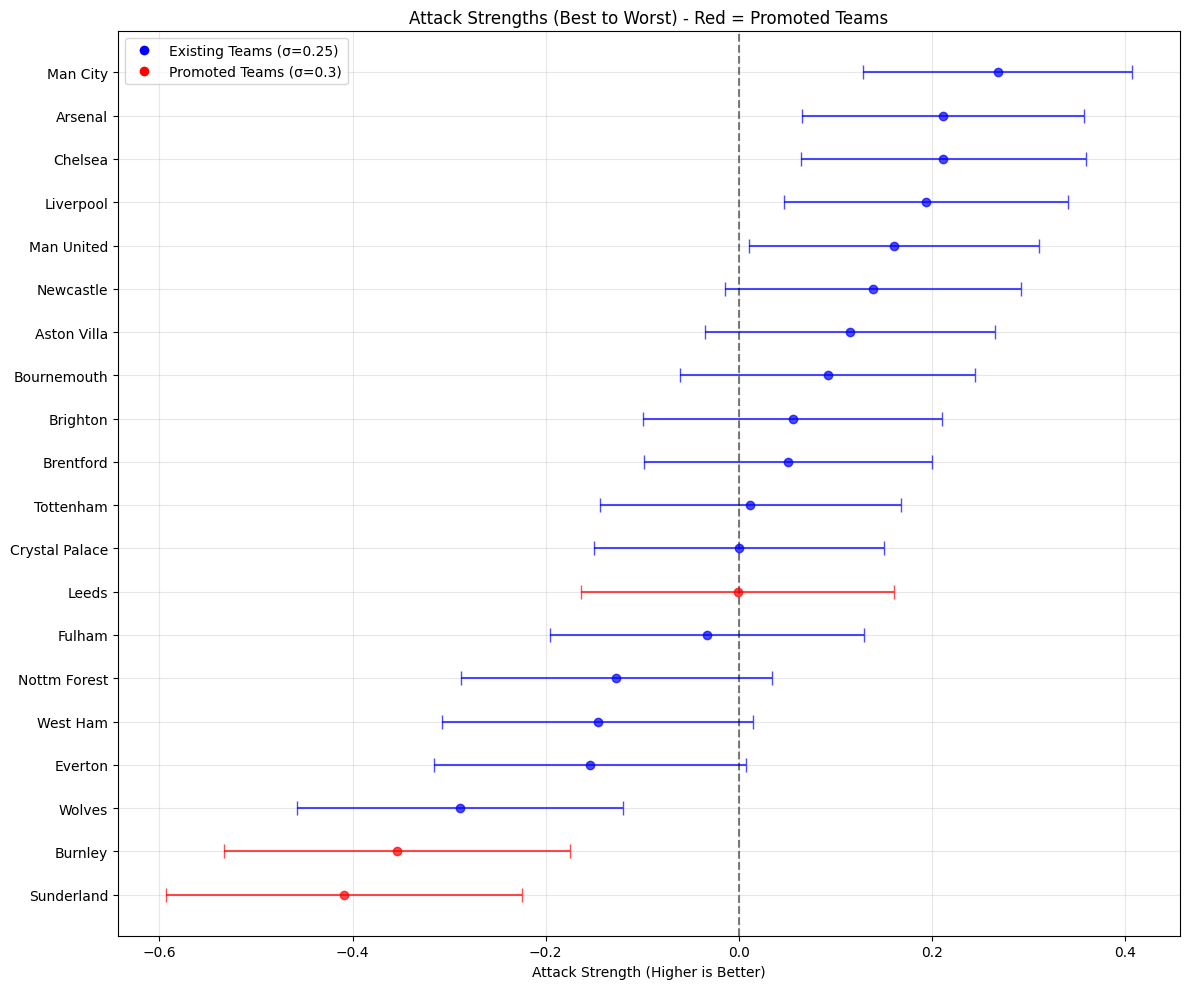

In [27]:
# Extract attack data
att_means = []
att_stds = []
att_team_names = []

for i in range(20):
    team_name = [k for k, v in team_mapping.items() if v == i][0]
    att_means.append(summary.loc[f'att_str[{i}]', 'mean'])
    att_stds.append(summary.loc[f'att_str[{i}]', 'sd'])
    att_team_names.append(team_name)

# Create DataFrame and sort by attack strength (higher is better attack)
att_data = list(zip(att_means, att_stds, att_team_names))
att_data_sorted = sorted(att_data, key=lambda x: x[0], reverse=True)  # Sort by mean (descending)

# Extract sorted data
sorted_att_means = [x[0] for x in att_data_sorted]
sorted_att_stds = [x[1] for x in att_data_sorted]
sorted_att_names = [x[2] for x in att_data_sorted]

# Create attack plot (best to worst)
fig, ax = plt.subplots(figsize=(12, 10))

promoted_teams = ['Burnley', 'Leeds', 'Sunderland']

for i, (mean, std, name) in enumerate(zip(sorted_att_means, sorted_att_stds, sorted_att_names)):
    color = 'red' if name in promoted_teams else 'blue'
    # Flip the y-position so best is at top
    ax.errorbar(mean, len(sorted_att_names)-1-i, xerr=std, fmt='o', capsize=5, 
                color=color, ecolor=color, alpha=0.7)

ax.set_yticks(range(len(sorted_att_names)))
ax.set_yticklabels(reversed(sorted_att_names))  # Reverse the labels to match
ax.set_xlabel('Attack Strength (Higher is Better)')
ax.set_title('Attack Strengths (Best to Worst) - Red = Promoted Teams')
ax.grid(True, alpha=0.3)
ax.axvline(x=0, color='black', linestyle='--', alpha=0.5)

# Add legend
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', 
                         markersize=8, label='Existing Teams (σ=0.25)'),
                  Line2D([0], [0], marker='o', color='w', markerfacecolor='red', 
                         markersize=8, label='Promoted Teams (σ=0.3)')]
ax.legend(handles=legend_elements)

plt.tight_layout()
plt.show()

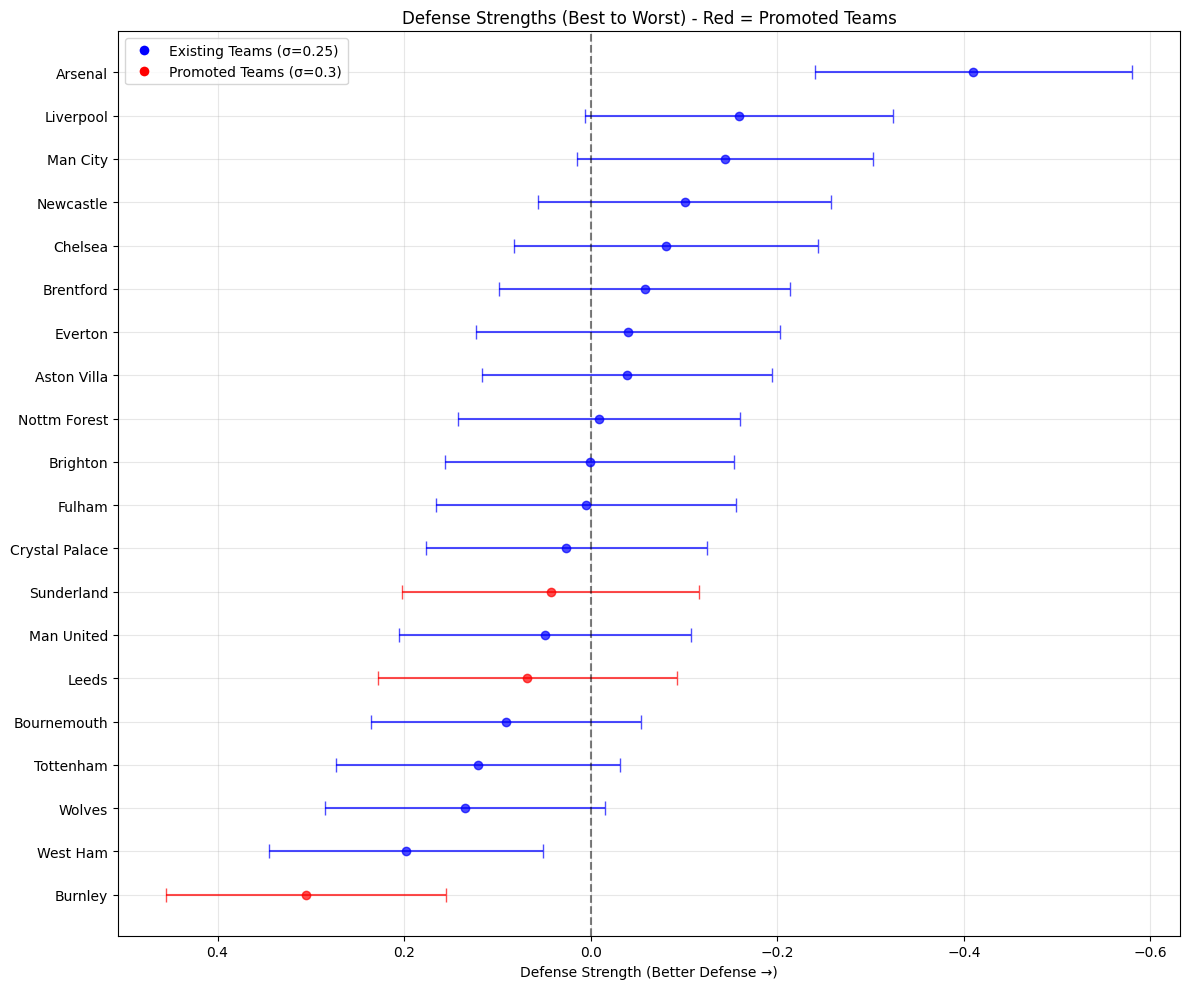

In [28]:
# Extract defense data
def_means = []
def_stds = []
def_team_names = []

for i in range(20):
    team_name = [k for k, v in team_mapping.items() if v == i][0]
    def_means.append(summary.loc[f'def_str[{i}]', 'mean'])
    def_stds.append(summary.loc[f'def_str[{i}]', 'sd'])
    def_team_names.append(team_name)

# Create DataFrame and sort by defense strength (lower is better defense)
def_data = list(zip(def_means, def_stds, def_team_names))
def_data_sorted = sorted(def_data, key=lambda x: x[0])  # Sort by mean (ascending)

# Extract sorted data
sorted_def_means = [x[0] for x in def_data_sorted]
sorted_def_stds = [x[1] for x in def_data_sorted]
sorted_def_names = [x[2] for x in def_data_sorted]

# Create defense plot (best to worst)
fig, ax = plt.subplots(figsize=(12, 10))
y_pos = np.arange(len(sorted_def_names))

promoted_teams = ['Burnley', 'Leeds', 'Sunderland']

for i, (mean, std, name) in enumerate(zip(sorted_def_means, sorted_def_stds, sorted_def_names)):
    color = 'red' if name in promoted_teams else 'blue'
    # Reverse y-position so best defense is at top
    ax.errorbar(mean, len(sorted_def_names)-1-i, xerr=std, fmt='o', capsize=5, 
                color=color, ecolor=color, alpha=0.7)

ax.set_yticks(range(len(sorted_def_names)))
ax.set_yticklabels(reversed(sorted_def_names))  # Reverse labels to match reversed positions
ax.set_xlabel('Defense Strength (Better Defense →)')
ax.set_title('Defense Strengths (Best to Worst) - Red = Promoted Teams')
ax.grid(True, alpha=0.3)
ax.axvline(x=0, color='black', linestyle='--', alpha=0.5)
ax.invert_xaxis()  # Flip x-axis so negative is to the right

# Add legend
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', 
                         markersize=8, label='Existing Teams (σ=0.25)'),
                  Line2D([0], [0], marker='o', color='w', markerfacecolor='red', 
                         markersize=8, label='Promoted Teams (σ=0.3)')]
ax.legend(handles=legend_elements)

plt.tight_layout()
plt.show()

In [29]:
# Establish pen predictions

# Penalty baselines (from analysis)
BASELINE_HOME_PENS = 0.157 * 0.78
BASELINE_AWAY_PENS = 0.101 * 0.78

In [30]:
# Team ratings vs average team (0 rating)
import numpy as np

# Get baseline and home advantage from trace
baseline_mean = summary.loc['baseline', 'mean']
home_adv_mean = summary.loc['home_adv', 'mean']

print("=== TEAM RATINGS VS AVERAGE TEAM ===")
print(f"Baseline (neutral venue): {baseline_mean:.3f}")
print(f"Home advantage: {home_adv_mean:.3f}")
print()

# Calculate goals for/against vs average team (0,0 ratings)
team_ratings = []

for team, idx in team_mapping.items():
    att_strength = summary.loc[f'att_str[{idx}]', 'mean']
    def_strength = summary.loc[f'def_str[{idx}]', 'mean']
    
    # Goals scored vs average team at home
    goals_for = np.exp(baseline_mean + att_strength + 0 ) + BASELINE_AWAY_PENS # vs avg def (0)

    
    # Goals conceded vs average team away
    goals_against = np.exp(baseline_mean + 0 + def_strength) + BASELINE_AWAY_PENS # avg att (0) with home adv
    
    goal_difference = goals_for - goals_against
    
    team_ratings.append({
        'team': team,
        'goals_for': goals_for,
        'goals_against': goals_against,
        'goal_diff_vs_avg': goal_difference,
    })

# Convert to DataFrame and sort by goal difference
ratings_df = pd.DataFrame(team_ratings)
ratings_df = ratings_df.sort_values('goal_diff_vs_avg', ascending=False)

print(f'Total Goals For: {ratings_df['goals_for'].sum():.2f}')
print(f'Total Goals Against: {ratings_df['goals_against'].sum():.2f}')
print()

# Display main table
print("TEAM RATINGS vs AVERAGE TEAM (sorted by goal difference):")
print("=" * 80)
display_df = ratings_df[['team', 'goals_for', 'goals_against', 'goal_diff_vs_avg']].copy()

pd.set_option('display.float_format', '{:.2f}'.format)
print(display_df.to_string(index=False))

=== TEAM RATINGS VS AVERAGE TEAM ===
Baseline (neutral venue): 0.108
Home advantage: 0.177

Total Goals For: 24.24
Total Goals Against: 24.09

TEAM RATINGS vs AVERAGE TEAM (sorted by goal difference):
          team  goals_for  goals_against  goal_diff_vs_avg
       Arsenal       1.46           0.82              0.64
      Man City       1.54           1.04              0.49
     Liverpool       1.43           1.03              0.40
       Chelsea       1.46           1.11              0.35
     Newcastle       1.36           1.09              0.27
   Aston Villa       1.33           1.15              0.18
    Man United       1.39           1.25              0.14
     Brentford       1.25           1.13              0.12
      Brighton       1.26           1.19              0.06
   Bournemouth       1.30           1.30              0.00
Crystal Palace       1.19           1.22             -0.03
        Fulham       1.16           1.20             -0.04
         Leeds       1.19       

In [31]:
# Team ratings vs average team (0 rating)
import numpy as np

# Get baseline and home advantage from trace
baseline_mean = summary.loc['baseline', 'mean']
home_adv_mean = summary.loc['home_adv', 'mean']

print("=== TEAM RATINGS VS AVERAGE TEAM ===")
print(f"Baseline (neutral venue): {baseline_mean:.3f}")
print(f"Home advantage: {home_adv_mean:.3f}")
print()

# Calculate goals for/against vs average team (0,0 ratings)
team_ratings = []
for team, idx in team_mapping.items():
    att_strength = summary.loc[f'att_str[{idx}]', 'mean']
    def_strength = summary.loc[f'def_str[{idx}]', 'mean']
    
    # Goals scored vs average team AT HOME
    goals_for_home = np.exp(baseline_mean + home_adv_mean + att_strength + 0) + BASELINE_HOME_PENS # vs avg def (0)
    
    # Goals scored vs average team AWAY
    goals_for_away = np.exp(baseline_mean + att_strength + 0) + BASELINE_AWAY_PENS # vs avg def (0), no home adv
    
    # Average goals for
    goals_for = (goals_for_home + goals_for_away) / 2
    
    # Goals conceded vs average team AT HOME (defending)
    goals_against_home = np.exp(baseline_mean + 0 + def_strength)  # avg att (0), no home adv for opponent
    
    # Goals conceded vs average team AWAY (defending)
    goals_against_away = np.exp(baseline_mean + home_adv_mean + 0 + def_strength)  # avg att (0) with opponent's home adv
    
    # Average goals against
    goals_against = (goals_against_home + goals_against_away) / 2
    
    goal_difference = goals_for - goals_against
    
    team_ratings.append({
        'team': team,
        'goals_for': goals_for,
        'goals_against': goals_against,
        'goal_diff_vs_avg': goal_difference,
    })

# Convert to DataFrame and sort by goal difference
ratings_df = pd.DataFrame(team_ratings)
ratings_df = ratings_df.sort_values('goal_diff_vs_avg', ascending=False)

print(f'Total Goals For: {ratings_df["goals_for"].sum():.2f}')
print(f'Total Goals Against: {ratings_df["goals_against"].sum():.2f}')
print()

# Display main table
print("TEAM RATINGS vs AVERAGE TEAM (sorted by goal difference):")
print("=" * 80)
display_df = ratings_df[['team', 'goals_for', 'goals_against', 'goal_diff_vs_avg']].copy()
pd.set_option('display.float_format', '{:.2f}'.format)
print(display_df.to_string(index=False))

=== TEAM RATINGS VS AVERAGE TEAM ===
Baseline (neutral venue): 0.108
Home advantage: 0.177

Total Goals For: 26.87
Total Goals Against: 24.69

TEAM RATINGS vs AVERAGE TEAM (sorted by goal difference):
          team  goals_for  goals_against  goal_diff_vs_avg
       Arsenal       1.61           0.81              0.80
      Man City       1.70           1.06              0.64
     Liverpool       1.58           1.04              0.54
       Chelsea       1.61           1.13              0.48
     Newcastle       1.50           1.10              0.40
   Aston Villa       1.47           1.18              0.30
    Man United       1.54           1.28              0.25
     Brentford       1.39           1.15              0.23
      Brighton       1.39           1.22              0.17
   Bournemouth       1.44           1.34              0.10
Crystal Palace       1.32           1.25              0.07
        Fulham       1.28           1.23              0.05
         Leeds       1.32       

In [32]:
import numpy as np
import pandas as pd

baseline_mean = summary.loc['baseline', 'mean']
home_adv_mean = summary.loc['home_adv', 'mean']

# Calculate expected goals for ALL possible matchups
all_teams = list(team_mapping.keys())
total_goals_all_matchups = 0
matchup_count = 0

# Track per-team statistics
team_stats = {team: {'goals_for': 0, 'goals_against': 0, 'matches': 0} for team in all_teams}

for home_team in all_teams:
    home_idx = team_mapping[home_team]
    home_att = summary.loc[f'att_str[{home_idx}]', 'mean']
    home_def = summary.loc[f'def_str[{home_idx}]', 'mean']
    
    for away_team in all_teams:
        if home_team == away_team:
            continue
            
        away_idx = team_mapping[away_team]
        away_att = summary.loc[f'att_str[{away_idx}]', 'mean']
        away_def = summary.loc[f'def_str[{away_idx}]', 'mean']
        
        # Calculate expected goals for this matchup
        home_goals = np.exp(baseline_mean + home_adv_mean + home_att + away_def) + BASELINE_HOME_PENS
        away_goals = np.exp(baseline_mean + away_att + home_def) + BASELINE_AWAY_PENS
        
        # Track totals
        total_goals_all_matchups += (home_goals + away_goals)
        matchup_count += 1
        
        # Track per-team stats
        team_stats[home_team]['goals_for'] += home_goals
        team_stats[home_team]['goals_against'] += away_goals
        team_stats[home_team]['matches'] += 1
        
        team_stats[away_team]['goals_for'] += away_goals
        team_stats[away_team]['goals_against'] += home_goals
        team_stats[away_team]['matches'] += 1

# Calculate averages per team
team_ratings = []
for team in all_teams:
    avg_goals_for = team_stats[team]['goals_for'] / team_stats[team]['matches']
    avg_goals_against = team_stats[team]['goals_against'] / team_stats[team]['matches']
    goal_diff = avg_goals_for - avg_goals_against
    
    team_ratings.append({
        'team': team,
        'goals_for': avg_goals_for,
        'goals_against': avg_goals_against,
        'goal_diff': goal_diff
    })

# Convert to DataFrame and sort
ratings_df = pd.DataFrame(team_ratings)
ratings_df = ratings_df.sort_values('goal_diff', ascending=False)

# Display results
avg_goals_per_match = total_goals_all_matchups / matchup_count

print("=" * 80)
print("AVERAGE GOALS ACROSS ALL POSSIBLE MATCHUPS")
print("=" * 80)
print(f"Average goals per match: {avg_goals_per_match:.2f}")
print(f"Total matchups analyzed: {matchup_count}")
print()

print("=" * 80)
print("TEAM RATINGS (sorted by goal difference)")
print("=" * 80)
pd.set_option('display.float_format', '{:.2f}'.format)
print(ratings_df[['team', 'goals_for', 'goals_against', 'goal_diff']].to_string(index=False))

print()
print("=" * 80)
print("SUMMARY")
print("=" * 80)
print(f"Total goals for (sum): {ratings_df['goals_for'].sum():.2f}")
print(f"Total goals against (sum): {ratings_df['goals_against'].sum():.2f}")
print(f"Average goals for per team: {ratings_df['goals_for'].mean():.2f}")
print(f"Average goals against per team: {ratings_df['goals_against'].mean():.2f}")

AVERAGE GOALS ACROSS ALL POSSIBLE MATCHUPS
Average goals per match: 2.71
Total matchups analyzed: 380

TEAM RATINGS (sorted by goal difference)
          team  goals_for  goals_against  goal_diff
       Arsenal       1.65           0.92       0.74
      Man City       1.73           1.16       0.57
     Liverpool       1.61           1.15       0.46
       Chelsea       1.63           1.23       0.40
     Newcastle       1.53           1.22       0.31
   Aston Villa       1.49           1.29       0.20
    Man United       1.55           1.40       0.15
     Brentford       1.40           1.27       0.13
      Brighton       1.41           1.34       0.06
   Bournemouth       1.45           1.46      -0.01
Crystal Palace       1.33           1.38      -0.04
        Fulham       1.30           1.35      -0.06
         Leeds       1.33           1.43      -0.10
       Everton       1.16           1.30      -0.14
  Nottm Forest       1.19           1.34      -0.15
     Tottenham       1.3

In [33]:
# Convert team_mapping dict to list of team names in index order
team_names = [None] * len(team_mapping)
for team, idx in team_mapping.items():
    team_names[idx] = team

# Save the trace with team names
trace_path = save_season_trace(
    trace=trace,
    season_year=2025.9,  # Replace with your actual season year
    league="Premier_League",       # Replace with your league code (e.g., "PL", "La Liga", etc.)
    team_names=team_names,
    model_version="manual_priors"
)

print(f"Trace saved to: {trace_path}")

Saved trace for 2025.9
Trace saved to: model_traces/manual_priors/trace_Premier_League_2025.9.nc


In [34]:
import numpy as np
import pandas as pd
import random

def predict_match(home_team, away_team, trace, team_mapping):
    """
    Predict goals for a match between two teams
    
    Parameters:
    home_team: str - name of home team
    away_team: str - name of away team  
    trace: pymc trace object
    team_mapping: dict - maps team names to indices
    
    Returns:
    dict with predictions
    """
    
    # Get team indices
    home_idx = team_mapping[home_team]
    away_idx = team_mapping[away_team]
    
    # Extract posterior samples
    att_str = trace.posterior['att_str'].values.reshape(-1, len(team_mapping))
    def_str = trace.posterior['def_str'].values.reshape(-1, len(team_mapping))
    baseline = trace.posterior['baseline'].values.flatten()
    home_adv = trace.posterior['home_adv'].values.flatten()
    
    # Calculate expected goals for each posterior sample
    home_goals_lambda = np.exp(
        baseline + 
        att_str[:, home_idx] + 
        def_str[:, away_idx] + 
        home_adv
    ) + BASELINE_HOME_PENS
    
    away_goals_lambda = np.exp(
        baseline + 
        att_str[:, away_idx] + 
        def_str[:, home_idx]
    ) + BASELINE_AWAY_PENS
    
    # Generate actual goal predictions using Poisson
    home_goals_pred = np.random.poisson(home_goals_lambda)
    away_goals_pred = np.random.poisson(away_goals_lambda)
    
    return {
        'home_team': home_team,
        'away_team': away_team,
        'home_goals_expected': np.mean(home_goals_lambda),
        'away_goals_expected': np.mean(away_goals_lambda),
        'home_goals_median': np.median(home_goals_pred),
        'away_goals_median': np.median(away_goals_pred),
        'home_win_prob': np.mean(home_goals_pred > away_goals_pred),
        'draw_prob': np.mean(home_goals_pred == away_goals_pred), 
        'away_win_prob': np.mean(home_goals_pred < away_goals_pred)
    }

matches = [
    ('Aston Villa', 'Brentford'),
    ('Brighton', 'Everton'),
    ('Chelsea', 'West Ham'),
    ('Leeds', 'Arsenal'),
    ('Liverpool', 'Newcastle'),
    ('Man United', 'Fulham'),
    ('Nottm Forest', 'Crystal Palace'),
    ('Sunderland', 'Burnley'),
    ('Tottenham', 'Man City'),
    ('Wolves', 'Bournemouth')
]

print("\n" + "="*60)
print("MATCH PREDICTIONS")
print("="*60)

total_goals = 0
for home, away in matches:
    result = predict_match(home, away, trace, team_mapping)
    match_total = result['home_goals_expected'] + result['away_goals_expected']
    total_goals += match_total
    print(f"{home:15} vs {away:15}: {result['home_goals_expected']:.2f}-{result['away_goals_expected']:.2f} "
          f"({result['home_win_prob']:.0%}-{result['draw_prob']:.0%}-{result['away_win_prob']:.0%}) "
          f"Total: {match_total:.1f}")

print("="*60)
print(f"TOTAL GOALS ACROSS ALL MATCHES: {total_goals:.2f}")
print(f"AVERAGE GOALS PER MATCH: {total_goals/len(matches):.2f}")


MATCH PREDICTIONS
Aston Villa     vs Brentford      : 1.57-1.23 (44%-25%-31%) Total: 2.8
Brighton        vs Everton        : 1.51-1.06 (48%-25%-27%) Total: 2.6
Chelsea         vs West Ham       : 2.17-0.99 (62%-19%-18%) Total: 3.2
Leeds           vs Arsenal        : 1.03-1.59 (25%-24%-51%) Total: 2.6
Liverpool       vs Newcastle      : 1.62-1.20 (46%-25%-29%) Total: 2.8
Man United      vs Fulham         : 1.73-1.24 (47%-25%-28%) Total: 3.0
Nottm Forest    vs Crystal Palace : 1.36-1.21 (41%-27%-32%) Total: 2.6
Sunderland      vs Burnley        : 1.36-0.92 (46%-28%-25%) Total: 2.3
Tottenham       vs Man City       : 1.32-1.76 (28%-23%-48%) Total: 3.1
Wolves          vs Bournemouth    : 1.24-1.51 (31%-25%-44%) Total: 2.8
TOTAL GOALS ACROSS ALL MATCHES: 27.63
AVERAGE GOALS PER MATCH: 2.76


In [40]:
def print_league_table(league_table):
    """Print formatted league table with xG stats"""
    
    # Convert to DataFrame for easier sorting
    df = pd.DataFrame.from_dict(league_table, orient='index')
    df = df.sort_values(['points', 'goal_difference', 'goals_for'], ascending=[False, False, False])
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'team'}, inplace=True)
    df.index = df.index + 1  # Start position from 1
    
    print("\n" + "="*110)
    print("PREDICTED FINAL LEAGUE TABLE (with Expected Goals)")
    print("="*110)
    print(f"{'Pos':>3} {'Team':15} {'P':>2} {'W':>2} {'D':>2} {'L':>2} {'GF':>3} {'GA':>3} {'GD':>4} {'xGF':>5} {'xGA':>5} {'xGD':>5} {'Pts':>3}")
    print("-"*110)
    
    for pos, row in df.iterrows():
        print(f"{pos:>3} {row['team']:15} {row['played']:>2} {row['wins']:>2} "
              f"{row['draws']:>2} {row['losses']:>2} {row['goals_for']:>3} "
              f"{row['goals_against']:>3} {row['goal_difference']:>+4} "
              f"{row['xg_for']:>5.1f} {row['xg_against']:>5.1f} {row['xg_difference']:>+5.1f} {row['points']:>3}")
    
    return df

def simulate_full_season(trace, team_mapping, df_actual):
    """Simulate a full season using actual results where available and simulating unplayed matches"""
    
    teams = list(team_mapping.keys())
    
    # Initialize league table with xG stats
    league_table = {team: {
        'played': 0,
        'wins': 0,
        'draws': 0,
        'losses': 0,
        'goals_for': 0,
        'goals_against': 0,
        'goal_difference': 0,
        'xg_for': 0.0,
        'xg_against': 0.0,
        'xg_difference': 0.0,
        'points': 0
    } for team in teams}
    
    all_matches = []
    
    # Create a set of played matches for quick lookup
    # Assuming df_actual has columns: home_team, away_team, is_actual
    played_matches = set()
    if df_actual is not None and 'is_actual' in df_actual.columns:
        actual_games = df_actual[df_actual['is_actual'] == True]
        for _, row in actual_games.iterrows():
            played_matches.add((row['home_team'], row['away_team']))
    
    # Generate all possible matches
    for home_team in teams:
        for away_team in teams:
            if home_team != away_team:
                
                # Check if this match has already been played
                if (home_team, away_team) in played_matches:
                    # Use actual result
                    actual_match = df_actual[
                        (df_actual['home_team'] == home_team) & 
                        (df_actual['away_team'] == away_team) & 
                        (df_actual['is_actual'] == True)
                    ].iloc[0]
                    
                    home_goals = int(actual_match['home_goals'])
                    away_goals = int(actual_match['away_goals'])
                    
                    # Get xG if available in the dataframe, otherwise predict
                    if 'home_xg' in actual_match and 'away_xg' in actual_match:
                        home_xg = actual_match['home_xg']
                        away_xg = actual_match['away_xg']
                    else:
                        result = predict_match(home_team, away_team, trace, team_mapping)
                        home_xg = result['home_goals_expected']
                        away_xg = result['away_goals_expected']
                    
                    match_result = {
                        'home_team': home_team,
                        'away_team': away_team,
                        'home_goals': home_goals,
                        'away_goals': away_goals,
                        'home_expected': home_xg,
                        'away_expected': away_xg,
                        'is_actual': True
                    }
                else:
                    # Simulate the match
                    result = predict_match(home_team, away_team, trace, team_mapping)
                    
                    home_goals = np.random.poisson(result['home_goals_expected'])
                    away_goals = np.random.poisson(result['away_goals_expected'])
                    
                    match_result = {
                        'home_team': home_team,
                        'away_team': away_team,
                        'home_goals': home_goals,
                        'away_goals': away_goals,
                        'home_expected': result['home_goals_expected'],
                        'away_expected': result['away_goals_expected'],
                        'is_actual': False
                    }
                
                all_matches.append(match_result)
                
                # Update league table for home team
                league_table[home_team]['played'] += 1
                league_table[home_team]['goals_for'] += home_goals
                league_table[home_team]['goals_against'] += away_goals
                league_table[home_team]['xg_for'] += match_result['home_expected']
                league_table[home_team]['xg_against'] += match_result['away_expected']
                
                if home_goals > away_goals:
                    league_table[home_team]['wins'] += 1
                    league_table[home_team]['points'] += 3
                elif home_goals == away_goals:
                    league_table[home_team]['draws'] += 1
                    league_table[home_team]['points'] += 1
                else:
                    league_table[home_team]['losses'] += 1
                
                # Update league table for away team
                league_table[away_team]['played'] += 1
                league_table[away_team]['goals_for'] += away_goals
                league_table[away_team]['goals_against'] += home_goals
                league_table[away_team]['xg_for'] += match_result['away_expected']
                league_table[away_team]['xg_against'] += match_result['home_expected']
                
                if away_goals > home_goals:
                    league_table[away_team]['wins'] += 1
                    league_table[away_team]['points'] += 3
                elif away_goals == home_goals:
                    league_table[away_team]['draws'] += 1
                    league_table[away_team]['points'] += 1
                else:
                    league_table[away_team]['losses'] += 1
    
    # Calculate differences
    for team in teams:
        league_table[team]['goal_difference'] = (
            league_table[team]['goals_for'] - league_table[team]['goals_against']
        )
        league_table[team]['xg_difference'] = (
            league_table[team]['xg_for'] - league_table[team]['xg_against']
        )
    
    return league_table, all_matches

# Usage:
print("Simulating full season with actual results...")
league_table, all_matches = simulate_full_season(trace, team_mapping, df)  # Pass your df here
final_table = print_league_table(league_table)

# Additional statistics showing actual vs simulated
actual_matches = sum(1 for match in all_matches if match.get('is_actual', False))
simulated_matches = len(all_matches) - actual_matches
total_goals = sum([match['home_goals'] + match['away_goals'] for match in all_matches])

print(f"\nSEASON STATISTICS:")
print(f"Actual matches: {actual_matches}")
print(f"Simulated matches: {simulated_matches}")
print(f"Total matches: {len(all_matches)}")
print(f"Total goals: {total_goals}")
print(f"Average goals per match: {total_goals/len(all_matches):.2f}")


Simulating full season with actual results...

PREDICTED FINAL LEAGUE TABLE (with Expected Goals)
Pos Team             P  W  D  L  GF  GA   GD   xGF   xGA   xGD Pts
--------------------------------------------------------------------------------------------------------------
  1 Arsenal         38 21 11  6  68  26  +42  64.3  35.7 +28.5  74
  2 Liverpool       38 19 12  7  70  43  +27  62.7  44.8 +17.9  69
  3 Aston Villa     38 19  8 11  55  43  +12  57.9  50.2  +7.7  65
  4 Brentford       38 18  8 12  51  41  +10  54.6  49.5  +5.1  62
  5 Man City        38 18  7 13  57  37  +20  67.1  45.2 +21.9  61
  6 Man United      38 15 13 10  62  51  +11  60.2  54.3  +5.9  58
  7 Chelsea         38 16  8 14  59  57   +2  63.5  48.1 +15.4  56
  8 Bournemouth     38 15 11 12  53  57   -4  56.3  56.6  -0.2  56
  9 Brighton        38 14 13 11  56  43  +13  54.7  52.2  +2.5  55
 10 Newcastle       38 15 10 13  51  46   +5  59.4  47.3 +12.1  55
 11 Fulham          38 15  8 15  44  47   -3  50.5  52

In [36]:
import numpy as np
import pandas as pd
from collections import defaultdict

def run_multiple_seasons(n_simulations, trace, team_mapping, df_actual):
    """Run multiple season simulations using actual results and return averaged results"""
    
    teams = list(team_mapping.keys())
    
    # Initialize accumulated statistics - now including xG
    accumulated_stats = {team: {
        'total_points': 0,
        'total_wins': 0,
        'total_draws': 0, 
        'total_losses': 0,
        'total_goals_for': 0,
        'total_goals_against': 0,
        'total_xg_for': 0.0,
        'total_xg_against': 0.0,
        'position_sum': 0
    } for team in teams}
    
    # Track position frequencies
    position_counts = {team: [0] * 20 for team in teams}  # 20 positions
    
    print(f"Running {n_simulations} season simulations...")
    
    for sim in range(n_simulations):
        if (sim + 1) % 1000 == 0:
            print(f"Completed {sim + 1} simulations...")
        
        # Run single season simulation with actual results
        league_table, _ = simulate_full_season(trace, team_mapping, df_actual)
        
        # Convert to DataFrame and sort
        df = pd.DataFrame.from_dict(league_table, orient='index')
        df = df.sort_values(['points', 'goal_difference', 'goals_for'], 
                           ascending=[False, False, False])
        df.reset_index(inplace=True)
        df.rename(columns={'index': 'team'}, inplace=True)
        
        # Accumulate statistics
        for pos, row in df.iterrows():
            team = row['team']
            final_position = pos + 1  # Position 1-20
            
            accumulated_stats[team]['total_points'] += row['points']
            accumulated_stats[team]['total_wins'] += row['wins']
            accumulated_stats[team]['total_draws'] += row['draws']
            accumulated_stats[team]['total_losses'] += row['losses']
            accumulated_stats[team]['total_goals_for'] += row['goals_for']
            accumulated_stats[team]['total_goals_against'] += row['goals_against']
            accumulated_stats[team]['total_xg_for'] += row['xg_for']
            accumulated_stats[team]['total_xg_against'] += row['xg_against']
            accumulated_stats[team]['position_sum'] += final_position
            
            # Track position frequency
            position_counts[team][pos] += 1
    
    # Calculate averages
    avg_results = []
    for team in teams:
        stats = accumulated_stats[team]
        avg_results.append({
            'team': team,
            'avg_points': stats['total_points'] / n_simulations,
            'avg_wins': stats['total_wins'] / n_simulations,
            'avg_draws': stats['total_draws'] / n_simulations,
            'avg_losses': stats['total_losses'] / n_simulations,
            'avg_goals_for': stats['total_goals_for'] / n_simulations,
            'avg_goals_against': stats['total_goals_against'] / n_simulations,
            'avg_xg_for': stats['total_xg_for'] / n_simulations,
            'avg_xg_against': stats['total_xg_against'] / n_simulations,
            'avg_position': stats['position_sum'] / n_simulations
        })
    
    # Create DataFrame and sort by average points
    avg_df = pd.DataFrame(avg_results)
    avg_df['avg_goal_difference'] = avg_df['avg_goals_for'] - avg_df['avg_goals_against']
    avg_df['avg_xg_difference'] = avg_df['avg_xg_for'] - avg_df['avg_xg_against']
    avg_df = avg_df.sort_values(['avg_points', 'avg_goal_difference', 'avg_goals_for'], 
                               ascending=[False, False, False])
    avg_df.reset_index(drop=True, inplace=True)
    avg_df.index = avg_df.index + 1
    
    return avg_df, position_counts

# Run simulations with actual results
n_sims = 100
print(f"Using actual results and simulating remaining fixtures...")
avg_table, position_freq = run_multiple_seasons(n_sims, trace, team_mapping, df)

# Count actual matches to calculate correct games per season
actual_matches_per_team = df[df['is_actual'] == True].groupby('home_team').size().mean() + \
                           df[df['is_actual'] == True].groupby('away_team').size().mean()
games_per_season = 38  # Total games in a full season

# Print averaged league table with per-game stats
print("\n" + "="*150)
print(f"AVERAGE LEAGUE TABLE OVER {n_sims:,} SIMULATIONS (Per Game Stats)")
print("="*150)
print(f"{'Pos':>3} {'Team':15} {'Pts':>5} {'W':>5} {'D':>5} {'L':>5} {'GF/G':>6} {'GA/G':>6} {'GD/G':>6} {'xGF/G':>7} {'xGA/G':>7} {'xGD/G':>7} {'Avg Pos':>8}")
print("-"*150)

for pos, row in avg_table.iterrows():
    print(f"{pos:>3} {row['team']:15} {row['avg_points']:5.1f} {row['avg_wins']:5.1f} "
          f"{row['avg_draws']:5.1f} {row['avg_losses']:5.1f} "
          f"{row['avg_goals_for']/games_per_season:6.2f} "
          f"{row['avg_goals_against']/games_per_season:6.2f} "
          f"{row['avg_goal_difference']/games_per_season:>+6.2f} "
          f"{row['avg_xg_for']/games_per_season:7.2f} "
          f"{row['avg_xg_against']/games_per_season:7.2f} "
          f"{row['avg_xg_difference']/games_per_season:>+7.2f} "
          f"{row['avg_position']:8.2f}")


Using actual results and simulating remaining fixtures...
Running 100 season simulations...

AVERAGE LEAGUE TABLE OVER 100 SIMULATIONS (Per Game Stats)
Pos Team              Pts     W     D     L   GF/G   GA/G   GD/G   xGF/G   xGA/G   xGD/G  Avg Pos
------------------------------------------------------------------------------------------------------------------------------------------------------
  1 Arsenal          76.7  22.5   9.3   6.2   1.71   0.81  +0.90    1.69    0.94   +0.75     1.47
  2 Man City         71.6  21.4   7.4   9.2   1.84   0.98  +0.85    1.76    1.19   +0.58     2.33
  3 Aston Villa      69.8  20.7   7.6   9.7   1.55   1.14  +0.41    1.52    1.32   +0.20     2.88
  4 Liverpool        62.0  17.1  10.8  10.1   1.53   1.25  +0.28    1.65    1.18   +0.47     5.25
  5 Chelsea          61.5  17.4   9.3  11.3   1.58   1.14  +0.45    1.67    1.26   +0.41     5.47
  6 Man United       58.1  15.2  12.4  10.3   1.65   1.43  +0.22    1.58    1.43   +0.16     7.05
  7 Newcast

In [37]:
pretty_df = ''

In [38]:
from datawrapper import Datawrapper
import pandas as pd

dw = Datawrapper(access_token = "ZVnOtN7rfXBTiW0BCZMKlhsUayDXBMoCRM39KzRRLmSj3Q1Far3V1FaSC0yIyhbM")

# ---- Team Logos (replace/add all 20 teams) ----
team_logos = {
    "Arsenal": "https://rawcdn.githack.com/louis-porter/prem_logos/main/Arsenal.png",
    # add other teams similarly
}

# ---- Team Colors ----
team_colors = {
    "Arsenal": "#EF0107",
    # add all teams...
}

# ---- Prepare DataFrame ----
pretty_df = avg_table.rename(columns={
    'team': 'Team',
    'avg_points': 'Points',
    'avg_wins': 'Wins',
    'avg_draws': 'Draws',
    'avg_losses': 'Losses',
    'avg_goals_for': 'Goals For',
    'avg_goals_against': 'Goals Against',
    'avg_goal_difference': 'Goal Diff',
})
pretty_df = pretty_df[
    ['Team', 'Points', 'Wins', 'Draws', 'Losses',
     'Goals For', 'Goals Against', 'Goal Diff']
]
pretty_df = pretty_df.round(2)
pretty_df = pretty_df[pretty_df["Team"] == 'Arsenal']

# ---- Add Logo Column with just the URL (no HTML) ----
pretty_df["Logo"] = pretty_df["Team"].map(team_logos)

# ---- Move logo column to the first position ----
pretty_df = pretty_df[
    ["Logo"] + [col for col in pretty_df.columns if col != "Logo"]
]

# ---- Create Table ----
chart = dw.create_chart(
    title="Average Premier League Table (Simulations)",
    chart_type="tables"
)

# Upload table data
dw.add_data(chart["id"], pretty_df)

# Update metadata with proper column format
metadata = {
    "data": {
        "column-format": {
            "Logo": {
                "type": "image",
                "height": 20
            }
        }
    },
    "visualize": {
        "table": {
            "show-header": True,
            "compact": True,
            "freeze-header": True,
            "allow-html": True,
            "vertical-padding": 2,
            "horizontal-padding": 4,
            "font-size": "12px",
            "striped": True,
            "line-height": 1.1
        }
    }
}

dw.update_metadata(chart["id"], metadata)

# Publish
dw.publish_chart(chart["id"])
print("Chart ID:", chart["id"])
print("Chart URL: https://app.datawrapper.de/chart/" + chart["id"])

/var/folders/7c/dkh0wxt56g39m3h9nmfq79mc0000gn/T/ipykernel_80798/879953049.py:45: DeprecationWarning: create_chart() is deprecated and will be removed in a future version. Use the object-oriented chart classes instead. Example: chart = BarChart(title='My Chart', data=df).create()
  chart = dw.create_chart(
/var/folders/7c/dkh0wxt56g39m3h9nmfq79mc0000gn/T/ipykernel_80798/879953049.py:51: DeprecationWarning: add_data() is deprecated and will be removed in a future version. Use the object-oriented chart classes instead. Example: chart = BarChart(title='My Chart', data=df).create() or chart.data = df; chart.update()
  dw.add_data(chart["id"], pretty_df)
This method is deprecated and will be removed in a future version. Use update_chart instead.
/var/folders/7c/dkh0wxt56g39m3h9nmfq79mc0000gn/T/ipykernel_80798/879953049.py:81: DeprecationWarning: publish_chart() is deprecated and will be removed in a future version. Use the object-oriented chart classes instead. Example: chart = BarChart.get

FailedRequestError: Request failed with status code 500. Response content: b'{"statusCode":500,"error":"Internal Server Error","message":"An internal server error occurred"}'

In [ ]:
# After creating the chart, print the metadata to see what's actually set:
print("Current metadata:")
import json
print(json.dumps(dw.chart_properties(chart["id"])['metadata'], indent=2))


This method is deprecated and will be removed in a future version. Use get_chart instead.


Current metadata:
{
  "data": {
    "changes": [],
    "transpose": false,
    "vertical-header": true,
    "horizontal-header": true
  },
  "describe": {
    "source-name": "",
    "source-url": "",
    "intro": "",
    "byline": "",
    "aria-description": "",
    "number-format": "-",
    "number-divisor": 0,
    "number-append": "",
    "number-prepend": ""
  },
  "visualize": {
    "dark-mode-invert": true,
    "highlighted-series": [],
    "highlighted-values": [],
    "sharing": {
      "enabled": false
    },
    "table": {
      "compact": true,
      "striped": true,
      "font-size": "12px",
      "allow-html": true,
      "line-height": 1.1,
      "show-header": true,
      "freeze-header": true,
      "vertical-padding": 2,
      "horizontal-padding": 4
    },
    "custom-columns": {
      "Logo": {
        "type": "html"
      }
    }
  },
  "axes": {},
  "publish": {
    "embed-width": 600,
    "embed-height": 400,
    "blocks": {
      "logo": {
        "enabled": fals

In [ ]:
# Check what the Logo column data looks like
print("\nLogo column data:")
print(pretty_df["Logo"].values)
print("\nFirst few rows of dataframe:")
print(pretty_df.head())


Logo column data:
['<img src="https://rawcdn.githack.com/louis-porter/prem_logos/main/Arsenal.png" height="20">']

First few rows of dataframe:
                                                                                          Logo     Team  Points  Wins  Draws  Losses  Goals For  Goals Against  Goal Diff
1  <img src="https://rawcdn.githack.com/louis-porter/prem_logos/main/Arsenal.png" height="20">  Arsenal   80.70 24.02   8.63    5.34      70.58          28.00      42.58
